<a href="https://colab.research.google.com/github/dustinlaa/beats-to-blocks/blob/dev/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## pip install dependencies

In [ ]:
# Installing dependencies and importing them

!pip install pyyaml
!pip install numpy
!pip install pretty_midi
!pip install mir_eval

import os
import regex as re
from pretty_midi import PrettyMIDI
import matplotlib.pyplot as plt
import numpy as np
import mir_eval.transcription
import pandas as pd
import seaborn as sns

## mount drive

In [ ]:
# mounting drive to obtain files
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## check if datasets are present

In [ ]:
os.chdir('/content/drive/MyDrive/beats-to-blocks/eval_datasets')
req_datasets = ['babyslakh_16k_jr']

# ensures that required datasets exist
for f in os.listdir('./'):
    if os.path.isdir(f) and f in req_datasets:
        req_datasets.remove(f)

assert len(req_datasets) == 0, f'MISSING DATASETS: {req_datasets}'
print('All datasets are present')

All datasets are present


## program num to instr class mapping

In [ ]:
'''
Set up this dictionary to create a program number -> instrument class mapping
'''
program_num_TO_instr_class = dict()
for i in range(0, 128):
    # piano
    if i in range(8):
        program_num_TO_instr_class[i] = "piano"

    # chromatic percussion
    if i in range(8, 16):
        program_num_TO_instr_class[i] = "chromatic percussion"

    # organ
    if i in range(16, 24):
        program_num_TO_instr_class[i] = "organ"

    # guitar
    if i in range(24, 33):
        program_num_TO_instr_class[i] = "guitar"

    # bass
    if i in range(33, 40):
        program_num_TO_instr_class[i] = "bass"

    # strings
    if i in range(40, 48):
        program_num_TO_instr_class[i] = "strings"

    # strings (continued)
    if i in range(48, 56):
        program_num_TO_instr_class[i] = "strings (continued)"

    # brass
    if i in range(56, 64):
        program_num_TO_instr_class[i] = "brass"

    # reed
    if i in range(64, 72):
        program_num_TO_instr_class[i] = "reed"

    # Pipe
    if i in range(72, 80):
        program_num_TO_instr_class[i] = "pipe"

    # Synth Lead
    if i in range(80, 88):
        program_num_TO_instr_class[i] = "synth lead"

    # Synth Pad
    if i in range(88, 96):
        program_num_TO_instr_class[i] = "synth pad"

    # Synth Effects
    if i in range(96, 104):
        program_num_TO_instr_class[i] = "synth effects"

    # Ethnic
    if i in range(104, 112):
        program_num_TO_instr_class[i] = "ethnic"

    # Percussive
    if i in range(112, 120):
        program_num_TO_instr_class[i] = "percussive"

    # Sound Effects
    if i in range(120, 128):
        program_num_TO_instr_class[i] = "sound effects"

## function to analyze midi files

In [ ]:
def get_inst_classes_in_track(path_to_midi):
    '''
    Takes a path to a .mid file and extracts the instrument classes that appear
    inside of it.

        Parameters
            path_to_midi (str): String containing file path to the midi file.

        Returns
            inst_classes (dict): A dictionary where the key is the instrument
            class and its value is how many instruments in the midi file fell
            under the instrument class.
    '''
    track_midi = PrettyMIDI(path_to_midi)
    inst_classes = dict()
    for inst in track_midi.instruments:
        if program_num_TO_instr_class[inst.program] not in inst_classes:
            inst_classes[program_num_TO_instr_class[inst.program]] = 0
        inst_classes[program_num_TO_instr_class[inst.program]] += 1

        if inst.is_drum:
            if 'drums' not in inst_classes:
                inst_classes['drums'] = 0
            inst_classes['drums'] += 1
    return inst_classes


## preprocess baby slakh jr midis for gorund truth

In [ ]:
os.chdir('/content/drive/MyDrive/beats-to-blocks/eval_datasets/babyslakh_16k_jr/')

inst_class_set = set()
true_track_inst_freqs = {}

# for each midi file in the dataset, get the instrument class frequencies
# this will be the ground truths for evaluation
for track_dir in sorted(os.listdir('./')):
    inst_classes_in_track = get_inst_classes_in_track(f'./{track_dir}/all_src.mid')
    true_track_inst_freqs[track_dir] = inst_classes_in_track

print(true_track_inst_freqs)


{'Track00001': {'guitar': 3, 'piano': 2, 'drums': 1, 'bass': 1, 'strings (continued)': 1, 'organ': 2, 'synth effects': 1}, 'Track00002': {'strings (continued)': 2, 'bass': 1, 'synth lead': 1, 'synth pad': 1, 'chromatic percussion': 1, 'piano': 2, 'guitar': 1, 'drums': 1, 'percussive': 1}, 'Track00003': {'piano': 2, 'bass': 1, 'guitar': 4, 'ethnic': 1, 'drums': 1}, 'Track00004': {'synth pad': 1, 'bass': 1, 'strings (continued)': 2, 'organ': 1, 'guitar': 1, 'piano': 2, 'drums': 1}, 'Track00005': {'piano': 3, 'drums': 1, 'guitar': 2, 'pipe': 3, 'bass': 1, 'chromatic percussion': 1, 'synth effects': 1, 'strings (continued)': 1, 'reed': 1}, 'Track00006': {'piano': 2, 'drums': 1, 'brass': 4, 'bass': 1, 'strings (continued)': 2, 'guitar': 3, 'reed': 1}, 'Track00007': {'piano': 3, 'drums': 1, 'bass': 1, 'guitar': 1, 'pipe': 1, 'strings (continued)': 1}, 'Track00008': {'bass': 1, 'piano': 3, 'drums': 1, 'guitar': 1, 'strings (continued)': 1, 'synth pad': 1}, 'Track00009': {'piano': 2, 'chromati

## preprocess pipeline1 instrument class predictions

In [ ]:
# below dir contains all babyslakh track predictions made by pipeline1
os.chdir("/content/drive/MyDrive/beats-to-blocks/eval_datasets_files/mt3")
pred_midi_paths = [pred_midi_path for pred_midi_path in os.listdir('./')]

pred_track_inst_freqs = dict()

# for each midi file generated by Pipeline #1, get the instrument class frequencies
# this will be the predictions for Pipeline #1 evaluation
for pred_midi_path in pred_midi_paths:
    key = pred_midi_path[:10]
    inst_classes_in_track = get_inst_classes_in_track(pred_midi_path)
    pred_track_inst_freqs[key] = inst_classes_in_track

print(pred_track_inst_freqs)

{'Track00001': {'guitar': 4, 'reed': 1, 'piano': 2, 'bass': 1, 'organ': 1, 'strings (continued)': 1, 'drums': 1}, 'Track00006': {'brass': 4, 'piano': 2, 'bass': 1, 'strings (continued)': 2, 'guitar': 2, 'drums': 1, 'pipe': 1, 'chromatic percussion': 1}, 'Track00008': {'piano': 3, 'guitar': 1, 'bass': 1, 'strings (continued)': 2, 'synth pad': 1, 'drums': 1}, 'Track00009': {'piano': 2, 'chromatic percussion': 1, 'strings (continued)': 3, 'reed': 1, 'bass': 1, 'pipe': 1, 'guitar': 1, 'drums': 1}, 'Track00007': {'bass': 1, 'piano': 3, 'guitar': 3, 'pipe': 1, 'strings (continued)': 1, 'reed': 2, 'drums': 1, 'brass': 1}, 'Track00002': {'synth lead': 1, 'strings (continued)': 2, 'guitar': 2, 'bass': 1, 'chromatic percussion': 1, 'synth pad': 1, 'piano': 2, 'drums': 1, 'brass': 2}, 'Track00005': {'guitar': 4, 'piano': 3, 'pipe': 1, 'chromatic percussion': 1, 'bass': 1, 'strings (continued)': 2, 'drums': 1}, 'Track00010': {'guitar': 2, 'bass': 1, 'piano': 2, 'synth pad': 1, 'synth lead': 1, 'st

In [ ]:
%matplotlib inline
#Show the plots in the notebook.

In [ ]:
'''
For the instrument classes found above for both ground truths and predictions,
if a midi file had 0 instruments that fell under a certain class, that class
is not included.  The code below fixes it so that in the case where an instrument
class is not present in a midi file, their frequency is set to 0.
'''
cumulative_true_inst_class_freq = dict()
cumulative_pred_inst_class_freq = dict()

# y_true
for track_freq in true_track_inst_freqs:
    for inst_class in true_track_inst_freqs[track_freq]:
        if inst_class not in cumulative_true_inst_class_freq:
            cumulative_true_inst_class_freq[inst_class] = 0
        cumulative_true_inst_class_freq[inst_class] = cumulative_true_inst_class_freq[inst_class] + true_track_inst_freqs[track_freq][inst_class]
# y_pred
for track_freq in pred_track_inst_freqs:
    for inst_class in pred_track_inst_freqs[track_freq]:
        if inst_class not in cumulative_pred_inst_class_freq:
            cumulative_pred_inst_class_freq[inst_class] = 0
        cumulative_pred_inst_class_freq[inst_class] = cumulative_pred_inst_class_freq[inst_class] + pred_track_inst_freqs[track_freq][inst_class]

# Make both y_true and y_pred of equal lenghts
for true_inst_class in cumulative_true_inst_class_freq:
    if true_inst_class not in cumulative_pred_inst_class_freq:
        # add it there but sinice it was not found in the preds, it would have 0 occs in the pred
        cumulative_pred_inst_class_freq[true_inst_class] = 0
for pred_inst_class in cumulative_pred_inst_class_freq:
    if pred_inst_class not in cumulative_true_inst_class_freq:
        # add it there but sinice it was not found among the ground truths, it would have 0 occs in the ground truths
        cumulative_true_inst_class_freq[pred_inst_class] = 0

print("y_true:", cumulative_true_inst_class_freq)
print("y_pred:", cumulative_pred_inst_class_freq)

y_true: {'guitar': 34, 'piano': 46, 'drums': 19, 'bass': 19, 'strings (continued)': 30, 'organ': 8, 'synth effects': 2, 'synth lead': 4, 'synth pad': 7, 'chromatic percussion': 7, 'percussive': 4, 'ethnic': 1, 'pipe': 7, 'reed': 5, 'brass': 7, 'strings': 3, 'sound effects': 1}
y_pred: {'guitar': 47, 'reed': 8, 'piano': 50, 'bass': 20, 'organ': 5, 'strings (continued)': 41, 'drums': 20, 'brass': 11, 'pipe': 9, 'chromatic percussion': 7, 'synth pad': 8, 'synth lead': 6, 'strings': 2, 'synth effects': 0, 'percussive': 0, 'ethnic': 0, 'sound effects': 0}


## Function to plot pred vs true frequencies of instrument classes

In [ ]:
def plot_pred_and_true_inst_class_freqs(cumulative_true_inst_class_freq, cumulative_pred_inst_class_freq, plot_title):
    '''
    bar plots showing on the x axis the name of inst_class and y-axis has its cumulative frequency across all tracks (from ground truths and predictions)

    Steps:
    Make a dict holding inst_class for ground truths and cum. freq
    Make a dict holding inst_class for predictions and cum. freq
    Make the plot
        Loop y_true and y_pred and store each inst_class in a set to avoid repeats
        Then make two empty lists : y_true_freqs and y_pred_freqs
        Loop the set of inst_classes
            if the class is in the cum_y_true_freqs append its value to the list
    '''
    true_inst_class_names = cumulative_true_inst_class_freq.keys()
    # pred_inst_class_names = cumulative_pred_inst_class_freq.keys()

    true_inst_class_freqs = cumulative_true_inst_class_freq.values()
    pred_inst_class_freqs = []

    for x in true_inst_class_names:
        if x in cumulative_pred_inst_class_freq:
            pred_inst_class_freqs.append(cumulative_pred_inst_class_freq[x])
        else:
            pred_inst_class_freqs.append(0)


    inst_class_counts = {
        "pred": np.array(list(pred_inst_class_freqs)),
        "true": np.array(list(true_inst_class_freqs)),
    }


    x = np.arange(len(true_inst_class_names))  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in inst_class_counts.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(plot_title)
    ax.set_xticks(x + width, true_inst_class_names, rotation=90)
    ax.legend(loc='upper right', ncols=3)

    plt.savefig(f'/content/drive/MyDrive/beats-to-blocks/plots/{plot_title}.png')

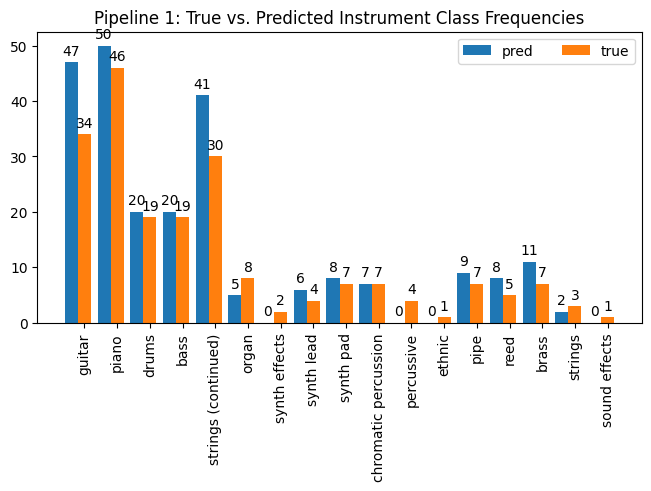

In [ ]:
plot_pred_and_true_inst_class_freqs(cumulative_true_inst_class_freq, cumulative_pred_inst_class_freq, 'Pipeline 1: True vs. Predicted Instrument Class Frequencies')

## pipeline 2 and 3 predictions

In [ ]:
'''
Pipeline 2 and 3 work:
Write code to loop through each of the Track_#_mixfiles folders, get the combined midi in each and make plot out of them
'''
os.chdir("/content/drive/MyDrive/beats-to-blocks/")
all_pred_pipeline_dict = dict()
for f in os.listdir('./'):
    if re.search("Track[0-9]*mix_files", f):
        # go through each pipeline in this Track folder
        for f2 in os.listdir(f'./{f}'):
            if re.search("pipeline[23]+", f2):
                if os.path.exists(f'./{f}/{f2}/{re.search("pipeline[23]+", f2).group()}_combined_midi_eval.mid'):
                    # print(f'./{f}/{f2}/{re.search("pipeline[23]+", f2).group()}_combined_midi_eval.mid')
                    pred_classes = get_inst_classes_in_track(f'./{f}/{f2}/{re.search("pipeline[23]+", f2).group()}_combined_midi_eval.mid')
                    if f'{re.search("pipeline[23]+", f2).group()}_preds' not in all_pred_pipeline_dict:
                        # set it
                        all_pred_pipeline_dict[f'{re.search("pipeline[23]+", f2).group()}_preds'] = pred_classes
                    else:
                        # loop all pred_classes and add them to existing classes
                        for a_inst_class in pred_classes:
                            if a_inst_class not in all_pred_pipeline_dict[f'{re.search("pipeline[23]+", f2).group()}_preds']:
                                # set it
                                all_pred_pipeline_dict[f'{re.search("pipeline[23]+", f2).group()}_preds'][a_inst_class] = pred_classes[a_inst_class]
                            else:
                                # add to it
                                all_pred_pipeline_dict[f'{re.search("pipeline[23]+", f2).group()}_preds'][a_inst_class] = all_pred_pipeline_dict[f'{re.search("pipeline[23]+", f2).group()}_preds'][a_inst_class] + pred_classes[a_inst_class]
                else:
                    print(f'./{f}/{f2}/{re.search("pipeline[23]+", f2).group()}_combined_midi_eval.mid')
print(all_pred_pipeline_dict)

{'pipeline3_preds': {'guitar': 72, 'strings': 43, 'organ': 19, 'strings (continued)': 45, 'chromatic percussion': 17, 'brass': 21, 'bass': 20, 'piano': 43, 'drums': 13, 'synth pad': 18, 'synth lead': 16, 'pipe': 7, 'reed': 5}, 'pipeline2_preds': {'piano': 50, 'drums': 21, 'bass': 18, 'guitar': 64, 'organ': 19, 'chromatic percussion': 15, 'strings (continued)': 40, 'pipe': 11, 'brass': 14, 'synth lead': 4, 'synth pad': 17, 'strings': 35, 'reed': 7}}


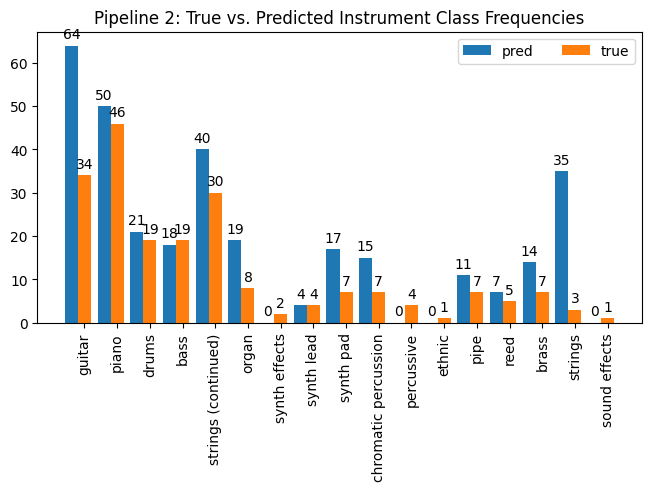

In [ ]:
# For pipeline 2
plot_pred_and_true_inst_class_freqs(cumulative_true_inst_class_freq, all_pred_pipeline_dict["pipeline2_preds"], 'Pipeline 2: True vs. Predicted Instrument Class Frequencies')

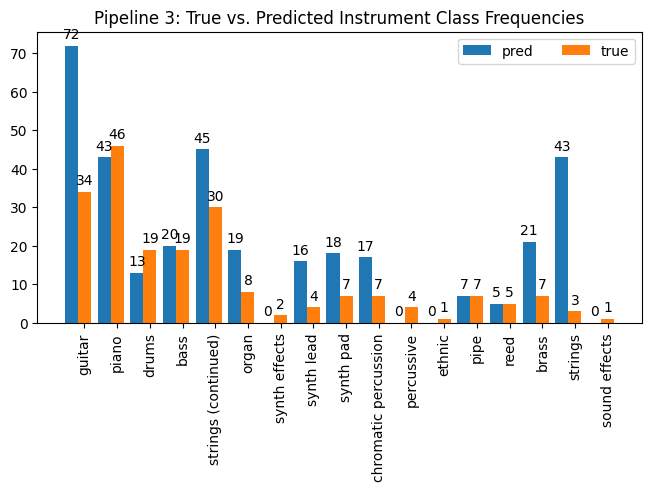

In [ ]:
# For pipeline 3
plot_pred_and_true_inst_class_freqs(cumulative_true_inst_class_freq, all_pred_pipeline_dict["pipeline3_preds"], 'Pipeline 3: True vs. Predicted Instrument Class Frequencies')

## note evaluation (precision, recall, f1, overlap)

In [ ]:
os.chdir("/content/drive/MyDrive/beats-to-blocks/eval_datasets/babyslakh_16k_jr")
true_midis = [PrettyMIDI(p + '/all_src.mid') for p in os.listdir('./')]
# create midi obj for each truth midi

def get_pipeline_1_preds():
	'''
	Obtains midi predictions of Pipline #1.

		Returns
			pred_midis (list): List of PrettyMIDI objects created from Pipeline
			#1 midi files.
	'''
	os.chdir("/content/drive/MyDrive/beats-to-blocks/")
	pred_midis = []
	for track_dir in sorted(os.listdir('./')):
		if 'Track0' in track_dir:
			track_name = track_dir[:13]
			path = f'{track_dir}/pipeline1/mt3_only/{track_name}.mid'
			print(path)
			pred_midis.append(PrettyMIDI(path))
	return pred_midis

def get_pipeline_2_3_preds(pipeline):
	'''
	Obtains midi predictions of either Pipeline #2 or #2.

		Parameters
			pipeline (int): Pipeline number; must be either 2 or 3.

		Returns
			pred_midis (list): List of PrettyMIDI objects created from Pipeline
			#2 or #3 midi files.
	'''
	assert pipeline == 3 or pipeline == 2, 'this function only works for pipelines 2 and 3'
	os.chdir("/content/drive/MyDrive/beats-to-blocks/")
	pred_midis = []
	for track_dir in sorted(os.listdir('./')):
		if 'Track0' in track_dir:
			path = f'{track_dir}/pipeline{pipeline}/pipeline{pipeline}_combined_midi_eval.mid'
			print(path)
			pred_midis.append(PrettyMIDI(path))
	return pred_midis

def get_pipeline_4_5_preds(pipeline):
	'''
	Obtains midi predictions of either Pipeline #4 or #5.

		Parameters
			pipeline (int): Pipeline number; must be either 4 or 5.

		Returns
			pred_midis (list): List of PrettyMIDI objects created from Pipeline
			#4 or #5 midi files.
	'''
	assert pipeline == 4 or pipeline == 5, 'this function only works for pipelines 4 and 5'
	os.chdir("/content/drive/MyDrive/beats-to-blocks/")
	pred_midis = []
	for track_dir in sorted(os.listdir('./')):
		if 'Track0' in track_dir:
			path = f'{track_dir}/pipeline{pipeline}/pipeline{pipeline}_combined_midi.mid'
			print(path)
			pred_midis.append(PrettyMIDI(path))
	return pred_midis

print('p1 preds')
pipeline1_pred_midis = get_pipeline_1_preds()
print('p2 preds')
pipeline2_pred_midis = get_pipeline_2_3_preds(2)
print('p3 preds')
pipeline3_pred_midis = get_pipeline_2_3_preds(3)
print('p4 preds')
pipeline4_pred_midis = get_pipeline_4_5_preds(4)
print('p5 preds')
pipeline5_pred_midis = get_pipeline_4_5_preds(5)

p1 preds
Track00001mix_files/pipeline1/mt3_only/Track00001mix.mid
Track00002mix_files/pipeline1/mt3_only/Track00002mix.mid
Track00003mix_files/pipeline1/mt3_only/Track00003mix.mid
Track00004mix_files/pipeline1/mt3_only/Track00004mix.mid
Track00005mix_files/pipeline1/mt3_only/Track00005mix.mid
Track00006mix_files/pipeline1/mt3_only/Track00006mix.mid
Track00007mix_files/pipeline1/mt3_only/Track00007mix.mid
Track00008mix_files/pipeline1/mt3_only/Track00008mix.mid
Track00009mix_files/pipeline1/mt3_only/Track00009mix.mid
Track00010mix_files/pipeline1/mt3_only/Track00010mix.mid
Track00011mix_files/pipeline1/mt3_only/Track00011mix.mid
Track00012mix_files/pipeline1/mt3_only/Track00012mix.mid
Track00013mix_files/pipeline1/mt3_only/Track00013mix.mid
Track00014mix_files/pipeline1/mt3_only/Track00014mix.mid
Track00015mix_files/pipeline1/mt3_only/Track00015mix.mid
Track00016mix_files/pipeline1/mt3_only/Track00016mix.mid
Track00017mix_files/pipeline1/mt3_only/Track00017mix.mid
Track00018mix_files/pi

In [ ]:
def formatted_midi_notes(midi):
	'''
		Returns list of notes from midi file sorted in order of
		onset time, then instrument program number.

			Parameters:
				midi (pretty_midi.PrettyMIDI): PrettyMIDI object,

			Returns:
				notes (list[pretty_midi.Note): List of Note objects sorted by onset time.
	'''
	notes = []
	for inst in midi.instruments:
		for note in inst.notes:
			notes.append(note)
	return sorted(notes, key=lambda note: (note.start, note.end)) # sort by start, then by end

def get_interval_info_in_midi(nparr, notes):
	'''
		Populates nparr with interval information, where col=0 is
		onset time and col=1 is offset time.  Assumes that the notes
		are formatted based on `formatted_midi_notes`.

			Parameters:
				nparr (np.array, shape=(n, 2), dtype=float): nparray of shape (n, 2), where n is len(notes).
				notes (pretty_midi.Note): list of PrettyMIDI Note objects.
	'''
	for i, note in enumerate(notes):
		nparr[i][0] = note.start
		nparr[i][1] = note.end

def get_eval_results(true_midis, pred_midis, transcription_eval_kwargs):
	'''
	Performs evaluation of predicted vs true notes for the following combinations
	of metrics:
	- Onset, Offset, and Pitch
	- Onset and Pitch
	It specifically computes precision, recall, f1, and overlap values, which are
	computed using mir_eval.transcription.precision_recall_f1_overlap().

		Parameters
			true_midis (list): List of PrettyMIDI objects created from ground
			truth midi files.
			pred_midis (list): List of PrettyMIDI objects created from
			generated/predicted midi files.
			transcription_eval_kwargs (dict): more keyword arguments that will be
			used in mir_eval.transcription.precision_recall_f1_overlap().

		Returns
			track_eval_results (list): List of evaluation results containing
			(precision, recall, f1, overlap) tuples for each predicted track.
	'''
	track_eval_results = []  # contains precision, recall, f1, and overlap results, where each index i corresponds to Track i + 1

	for (true_midi, pred_midi) in zip(true_midis, pred_midis):
		true_midi_notes = formatted_midi_notes(true_midi)
		pred_midi_notes = formatted_midi_notes(pred_midi)

		n = len(true_midi_notes)
		m = len(pred_midi_notes)

		true_intervals = np.zeros((n, 2))
		get_interval_info_in_midi(true_intervals, true_midi_notes)
		true_pitches = np.array([note.pitch for note in true_midi_notes])

		pred_intervals = np.zeros((m, 2))
		get_interval_info_in_midi(pred_intervals, pred_midi_notes)
		pred_pitches = np.array([note.pitch for note in pred_midi_notes])

		track_eval_results.append(mir_eval.transcription.precision_recall_f1_overlap(
			ref_intervals=true_intervals,
			ref_pitches=true_pitches,
			est_intervals=pred_intervals,
			est_pitches=pred_pitches,
			**transcription_eval_kwargs
		))

	return track_eval_results


def get_eval_results_onset_only(true_midis, pred_midis, transcription_onset_eval_kwargs):
	'''
	Performs evaluation of predicted vs true notes in regards to onset accuracy.
	It specifically computes precision, recall, and f1, which are computed using
	mir_eval.transcription.onset_precision_recall_f1().

		Parameters
			true_midis (list): List of PrettyMIDI objects created from ground
			truth midi files.
			pred_midis (list): List of PrettyMIDI objects created from
			generated/predicted midi files.
			transcription_onset_eval_kwargs (dict): more keyword arguments that
			will be used in mir_eval.transcription.precision_recall_f1_overlap().

		Returns
			track_eval_results (list): List of evaluation results containing
			(precision, recall, f1) tuples for each predicted track.
	'''
	eval_results = []

	for (true_midi, pred_midi) in zip(true_midis, pred_midis):
		true_midi_notes = formatted_midi_notes(true_midi)
		pred_midi_notes = formatted_midi_notes(pred_midi)

		n = len(true_midi_notes)
		m = len(pred_midi_notes)

		true_intervals = np.zeros((n, 2))
		get_interval_info_in_midi(true_intervals, true_midi_notes)

		pred_intervals = np.zeros((m, 2))
		get_interval_info_in_midi(pred_intervals, pred_midi_notes)

		eval_results.append(mir_eval.transcription.onset_precision_recall_f1(
			   ref_intervals=true_intervals,
			   est_intervals=pred_intervals,
			   **transcription_onset_eval_kwargs
		))

	return eval_results


def get_eval_results_offset_only(true_midis, pred_midis, transcription_offset_eval_kwargs):
	'''
	Performs evaluation of predicted vs true notes in regards to offset accuracy.
	It specifically computes precision, recall, and f1, which are computed using
	mir_eval.transcription.offset_precision_recall_f1().

		Parameters
			true_midis (list): List of PrettyMIDI objects created from ground
			truth midi files.
			pred_midis (list): List of PrettyMIDI objects created from
			generated/predicted midi files.
			transcription_offset_eval_kwargs (dict): more keyword arguments that
			will be used in mir_eval.transcription.offset_precision_recall_f1().

		Returns
			track_eval_results (list): List of evaluation results containing
			(precision, recall, f1) tuples for each predicted track.
	'''
	eval_results = []

	for (true_midi, pred_midi) in zip(true_midis, pred_midis):
		true_midi_notes = formatted_midi_notes(true_midi)
		pred_midi_notes = formatted_midi_notes(pred_midi)

		n = len(true_midi_notes)
		m = len(pred_midi_notes)

		true_intervals = np.zeros((n, 2))
		get_interval_info_in_midi(true_intervals, true_midi_notes)

		pred_intervals = np.zeros((m, 2))
		get_interval_info_in_midi(pred_intervals, pred_midi_notes)

		eval_results.append(mir_eval.transcription.offset_precision_recall_f1(
			   ref_intervals=true_intervals,
			   est_intervals=pred_intervals,
			   **transcription_offset_eval_kwargs
		))

	return eval_results


def get_avg_of_offset_onset_results(results):  # returns a tuple of averaged precision, recall, and f1 scores
	'''
	Computes the average precision, recall, and f1 values over all tracks, which
	were computed using get_eval_results_offset_only() or get_eval_results_onset_only().

		Parameters
			results (list): List of evaluation results containing (precision, recall, f1)
			tuples for each predicted track.

		Returns
			avg_precision: Average precision over all tracks in results.
			avg_recall: Average recall over all tracks in results.
			avg_f1: Average f1 score over all tracks in results.
	'''
	avg_precision = 0
	avg_recall = 0
	avg_f1 = 0
	for (precision, recall, f1) in results:
		avg_precision += precision
		avg_recall += recall
		avg_f1 += f1
	len_results = len(results)
	return (
		   avg_precision / len_results,
		   avg_recall / len_results,
		   avg_f1 /len_results
	)


def get_avg_of_results(results):  # returns a tuple of averaged precision, recall, f1, and overlap scores in that order
	'''
	Computes the average precision, recall, f1, and overlap values over all tracks, which
	were computed using get_eval_results().

		Parameters
			results (list): List of evaluation results containing (precision, recall, f1, overlap)
			tuples for each predicted track.

		Returns
			avg_precision: Average precision over all tracks in results.
			avg_recall: Average recall over all tracks in results.
			avg_f1: Average f1 score over all tracks in results.
			avg_overlap: Average overlap over all tracks in results.
	'''
	avg_precision = 0
	avg_recall = 0
	avg_f1 = 0
	avg_overlap = 0
	for (precision, recall, f1, overlap) in results:
		avg_precision += precision
		avg_recall += recall
		avg_f1 += f1
		avg_overlap += overlap
	len_results = len(results)
	return (
		   avg_precision / len_results,
		   avg_recall / len_results,
		   avg_f1 / len_results,
		   avg_overlap / len_results
	)


ONSET_THRESH = 0.1
OFFSET_RATIO_THRESH = 0.2
OFFSET_THRESH = 0.1

eval_onset_offset_pitch_params = {  # onset, offset, and pitch accuracy evaluation params
		'onset_tolerance': ONSET_THRESH,
		'offset_ratio': OFFSET_RATIO_THRESH,
		'offset_min_tolerance': OFFSET_THRESH
}

eval_onset_pitch_params = {  # onset and pitch accuracy evaluation params
	   'onset_tolerance': ONSET_THRESH,
	   'offset_ratio': None
}

eval_onset_params = {  # onset evaluation params
	   'onset_tolerance': ONSET_THRESH
}

eval_offset_params = {  # offset evaluation params
	   'offset_ratio': OFFSET_RATIO_THRESH,
	   'offset_min_tolerance': OFFSET_THRESH
}

results_onset_offset_pitch = {  # pipeline performance when evaluated with onset, offset, and pitch accuracy
		'p1': get_avg_of_results(get_eval_results(true_midis, pipeline1_pred_midis, eval_onset_offset_pitch_params)),
		'p2': get_avg_of_results(get_eval_results(true_midis, pipeline2_pred_midis, eval_onset_offset_pitch_params)),
		'p3': get_avg_of_results(get_eval_results(true_midis, pipeline3_pred_midis, eval_onset_offset_pitch_params)),
		'p4': get_avg_of_results(get_eval_results(true_midis, pipeline4_pred_midis, eval_onset_offset_pitch_params)),
		'p5': get_avg_of_results(get_eval_results(true_midis, pipeline5_pred_midis, eval_onset_offset_pitch_params))
}

results_onset_pitch = {  # pipeline performance when evaluated with onset and pitch accuracy
		'p1': get_avg_of_results(get_eval_results(true_midis, pipeline1_pred_midis, eval_onset_pitch_params)),
		'p2': get_avg_of_results(get_eval_results(true_midis, pipeline2_pred_midis, eval_onset_pitch_params)),
		'p3': get_avg_of_results(get_eval_results(true_midis, pipeline3_pred_midis, eval_onset_pitch_params)),
		'p4': get_avg_of_results(get_eval_results(true_midis, pipeline4_pred_midis, eval_onset_pitch_params)),
		'p5': get_avg_of_results(get_eval_results(true_midis, pipeline5_pred_midis, eval_onset_pitch_params))
}

results_onset = {  # pipeline performance when evaluated with only onset accuracy
		'p1': get_avg_of_offset_onset_results(get_eval_results_onset_only(true_midis, pipeline1_pred_midis, eval_onset_params)),
		'p2': get_avg_of_offset_onset_results(get_eval_results_onset_only(true_midis, pipeline2_pred_midis, eval_onset_params)),
		'p3': get_avg_of_offset_onset_results(get_eval_results_onset_only(true_midis, pipeline3_pred_midis, eval_onset_params)),
		'p4': get_avg_of_offset_onset_results(get_eval_results_onset_only(true_midis, pipeline4_pred_midis, eval_onset_params)),
		'p5': get_avg_of_offset_onset_results(get_eval_results_onset_only(true_midis, pipeline5_pred_midis, eval_onset_params))
}

results_offset = {  # pipeline performance when evaluated with only offset accuracy
		'p1': get_avg_of_offset_onset_results(get_eval_results_offset_only(true_midis, pipeline1_pred_midis, eval_offset_params)),
		'p2': get_avg_of_offset_onset_results(get_eval_results_offset_only(true_midis, pipeline2_pred_midis, eval_offset_params)),
		'p3': get_avg_of_offset_onset_results(get_eval_results_offset_only(true_midis, pipeline3_pred_midis, eval_offset_params)),
		'p4': get_avg_of_offset_onset_results(get_eval_results_offset_only(true_midis, pipeline4_pred_midis, eval_offset_params)),
		'p5': get_avg_of_offset_onset_results(get_eval_results_offset_only(true_midis, pipeline5_pred_midis, eval_offset_params))
}


print(results_onset_offset_pitch) # (precision, recall, f1, overlap)
print(results_onset_pitch) # (precision, recall, f1, overlap)
print(results_onset) # (precision, recall, f1)
print(results_offset) # (precision, recall, f1)


{'p1': (0.16286318072715236, 0.14723236286739502, 0.14341180620469463, 0.16367978672313346), 'p2': (0.11329053631169443, 0.1256781903674622, 0.10823344105133317, 0.2371913505926968), 'p3': (0.09500962227398552, 0.09525077649980973, 0.08552740284138381, 0.2134620911506424), 'p4': (0.06724301982744363, 0.043060596292707025, 0.05011767224009818, 0.622875666471368), 'p5': (0.06718663416790098, 0.042943938811626316, 0.049698533946061114, 0.6047517743727595)}
{'p1': (0.28272734026903856, 0.25146368896744054, 0.2383312129876518, 0.08005247700889813), 'p2': (0.2329611802956036, 0.24200048182341632, 0.208157348696104, 0.1267762845765052), 'p3': (0.21945543903742215, 0.2007899203111604, 0.18059570637292688, 0.14000223485451896), 'p4': (0.21436664409069633, 0.15307657439039815, 0.1682818487836649, 0.2865357607948337), 'p5': (0.2143553244666488, 0.15376775497946227, 0.16751336848254944, 0.28922052356330746)}
{'p1': (0.5543265255893083, 0.505280655987628, 0.46998981292012265), 'p2': (0.507586692392

In [ ]:
df_for_results_onset_offset_pitch = pd.DataFrame(results_onset_offset_pitch, index=["precision", "recall", "f1", "overlap"])
df_for_results_onset_pitch = pd.DataFrame(results_onset_pitch, index=["precision", "recall", "f1", "overlap"])
df_for_results_onset = pd.DataFrame(results_onset, index=["precision", "recall", "f1"])
df_for_results_offset = pd.DataFrame(results_offset, index=["precision", "recall", "f1"])

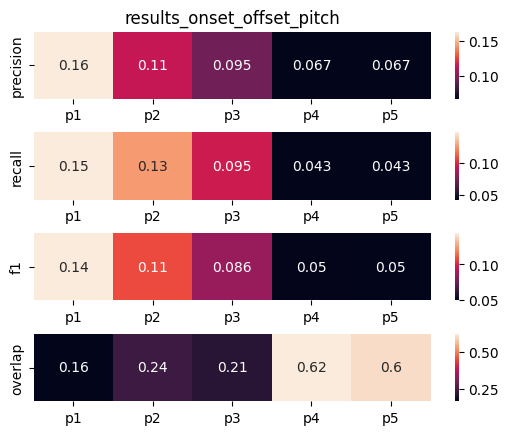

In [ ]:
# loop all rows of dfs above and generate heatmap
fig, ax = plt.subplots(len(df_for_results_onset_offset_pitch.index))
for row in range(len(df_for_results_onset_offset_pitch.index)):
    sns.heatmap(df_for_results_onset_offset_pitch.iloc[[row], :], annot=True, ax=ax[row])
plt.subplots_adjust(wspace=0.8, hspace=0.5)
ax[0].set_title("results_onset_offset_pitch")
plt.savefig("/content/drive/MyDrive/beats-to-blocks/plots/results_onset_offset_pitch.png")

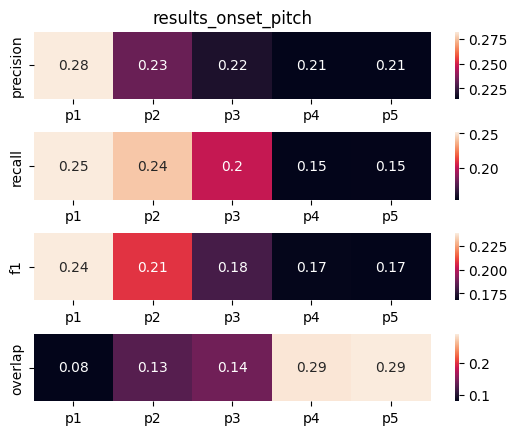

In [ ]:
fig, ax = plt.subplots(len(df_for_results_onset_pitch.index))
for row in range(len(df_for_results_onset_pitch.index)):
    sns.heatmap(df_for_results_onset_pitch.iloc[[row], :], annot=True, ax=ax[row])
ax[0].set_title("results_onset_pitch")
plt.subplots_adjust(wspace=0.8, hspace=0.5)
plt.savefig("/content/drive/MyDrive/beats-to-blocks/plots/results_onset_pitch.png")

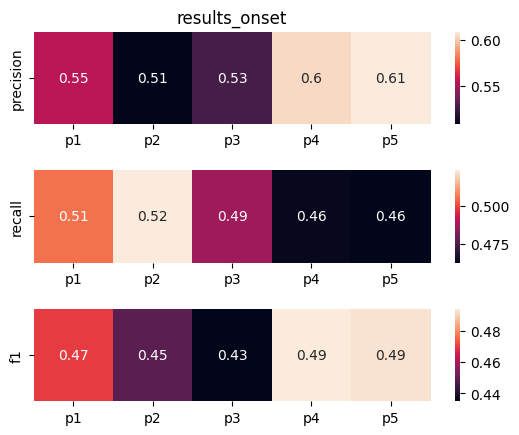

In [ ]:
fig, ax = plt.subplots(len(df_for_results_onset.index))
for row in range(len(df_for_results_onset.index)):
    sns.heatmap(df_for_results_onset.iloc[[row], :], annot=True, ax=ax[row])
ax[0].set_title("results_onset")
plt.subplots_adjust(wspace=0.8, hspace=0.5)
plt.savefig("/content/drive/MyDrive/beats-to-blocks/plots/results_onset.png")

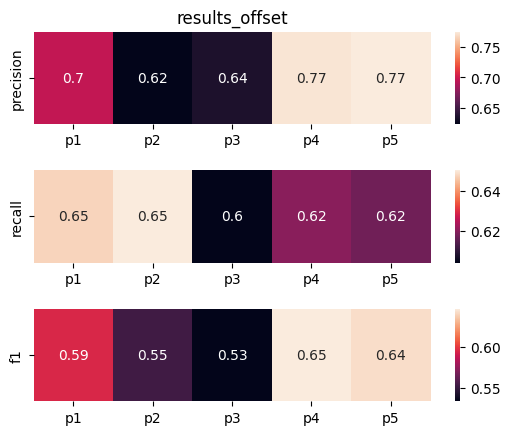

In [ ]:
fig, ax = plt.subplots(len(df_for_results_offset.index))
for row in range(len(df_for_results_offset.index)):
    sns.heatmap(df_for_results_offset.iloc[[row], :], annot=True, ax=ax[row])
ax[0].set_title("results_offset")
plt.subplots_adjust(wspace=0.8, hspace=0.5)
plt.savefig("/content/drive/MyDrive/beats-to-blocks/plots/results_offset.png")